This notebook contains an implementation of SPONGENT-16, an experimental scaled-down quantum implementation of the SPONGENT hash function.

In [6]:
from qiskit import QuantumCircuit

In [7]:
B = 20 # Width of the hash function
C = 16 # The capacity of the hash function
R = 4 # Rate of the hash function
ROUNDS = 10 # Number of rounds in the permutation

Below the 4-qubit sbox is implemented. The least significant bit of the bitstring corresponds to the first qubit from the top.

In [8]:
def sbox_circuit():
    circuit = QuantumCircuit(4)

    circuit.x(1)
    circuit.ccx(2,1,0)
    circuit.cx(1,2)
    circuit.cx(3,0)
    circuit.cx(0,1)
    circuit.x(0)
    circuit.ccx(3,2,1)
    circuit.ccx(1,0,3)
    circuit.x(1)
    circuit.cx(2,0)             
    circuit.ccx(3,1,2)          
    circuit.cx(2,1)             
    circuit.cx(0,3)             

    return circuit, circuit.to_gate(label="SBOX")


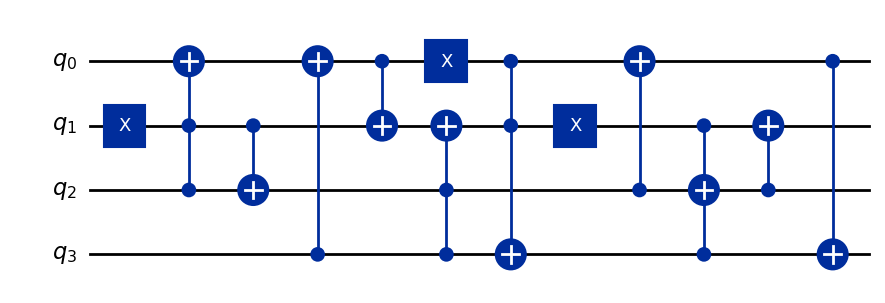

In [9]:
test_sbox_circuit, _ = sbox_circuit()
test_sbox_circuit.draw("mpl")

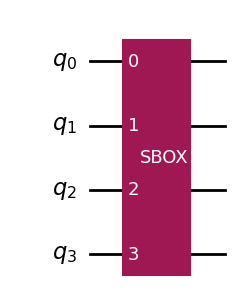

In [10]:
test_sbox_gate = QuantumCircuit(4)
test_sbox_gate.append(sbox_circuit()[1], [0,1,2,3])
test_sbox_gate.draw("mpl")

The `get_permuted_index` will be used to renumber the qubits before progressing to the next round of the permutation.

In [11]:
def get_permuted_index(index, width=20):
    assert 0 <= index < width

    if 0 <= index <= width - 2:
        return int((index * width / 4) % (width - 1))
    else:
        return index

For the `lCounter` layer, a 4-bit LFSR with taps on 2nd and 3rd bits is used.

In [12]:
def lfsr_state(round, initial_state='0100', taps=[2,3]):
    state = list(map(int, initial_state))
    
    for _ in range(round):
        feedback_bit = 0
        for tap in taps:
            feedback_bit ^= state[tap]
        
        state = [feedback_bit] + state[:-1]
    
    return ''.join(map(str, state))

def l_counter_circuit(round, width=B):
    state = lfsr_state(round)
    
    circuit = QuantumCircuit(width)

    for qubit, i in enumerate(state[::-1]):
        if i == '1':
            circuit.x(qubit)
            circuit.x(19 - qubit)

    return circuit, circuit.to_gate(label=f"lCounter{round} ({state})")


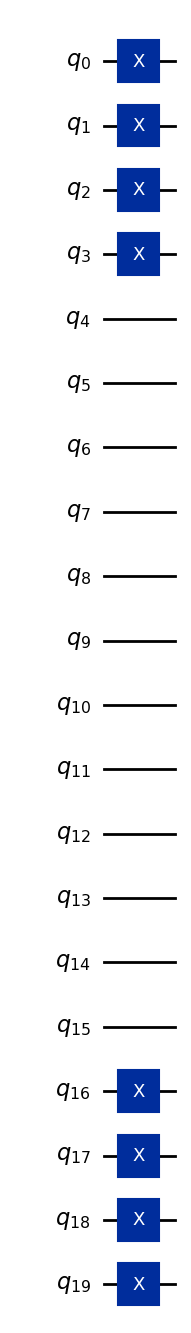

In [13]:
test_l_counter_circuit, _ = l_counter_circuit(10)
test_l_counter_circuit.draw(output="mpl")

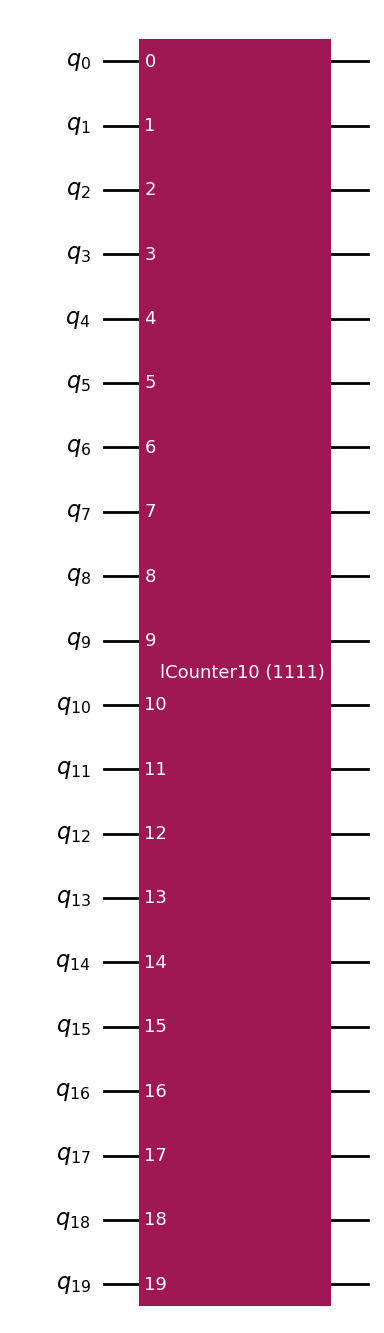

In [14]:
test_l_counter_gate = QuantumCircuit(20)
test_l_counter_gate.append(l_counter_circuit(10)[1], list(range(20)))
test_l_counter_gate.draw("mpl")

Now we compose the circuits above to create the full PI-20 permutation.

In [15]:
def permutation_stage_gate(round):
    _, l_counter_gate = l_counter_circuit(round)
    _, sbox_gate = sbox_circuit()
    
    circuit = QuantumCircuit(20)
    circuit.append(l_counter_gate, list(range(20)))

    for i in range(0, 20, 4):
        circuit.append(sbox_gate, list(range(i, i + 4)))
    
    return circuit, circuit.to_gate(label=f"Permutation{round}")


In [16]:
[get_permuted_index(i) for i in range(20)]

[0, 5, 10, 15, 1, 6, 11, 16, 2, 7, 12, 17, 3, 8, 13, 18, 4, 9, 14, 19]

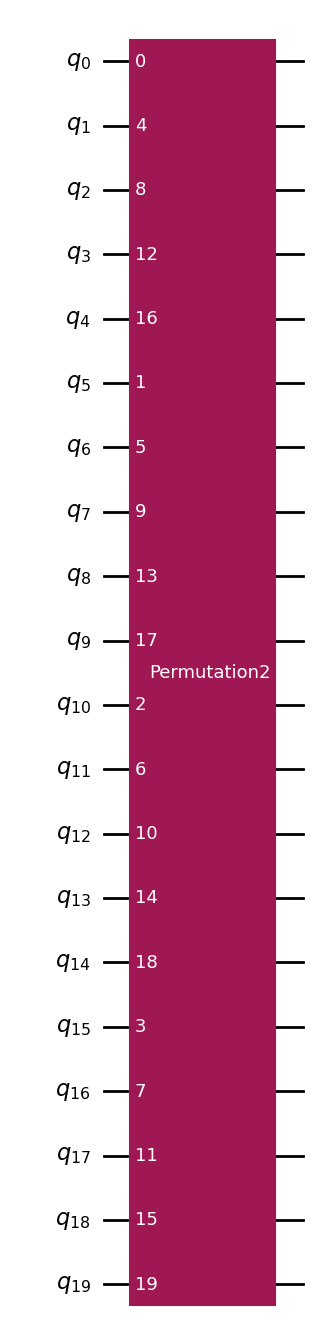

In [17]:
test_permutation = QuantumCircuit(20)
test_permutation.append(permutation_stage_gate(2)[1], [get_permuted_index(i) for i in range(20)])
test_permutation.draw("mpl")

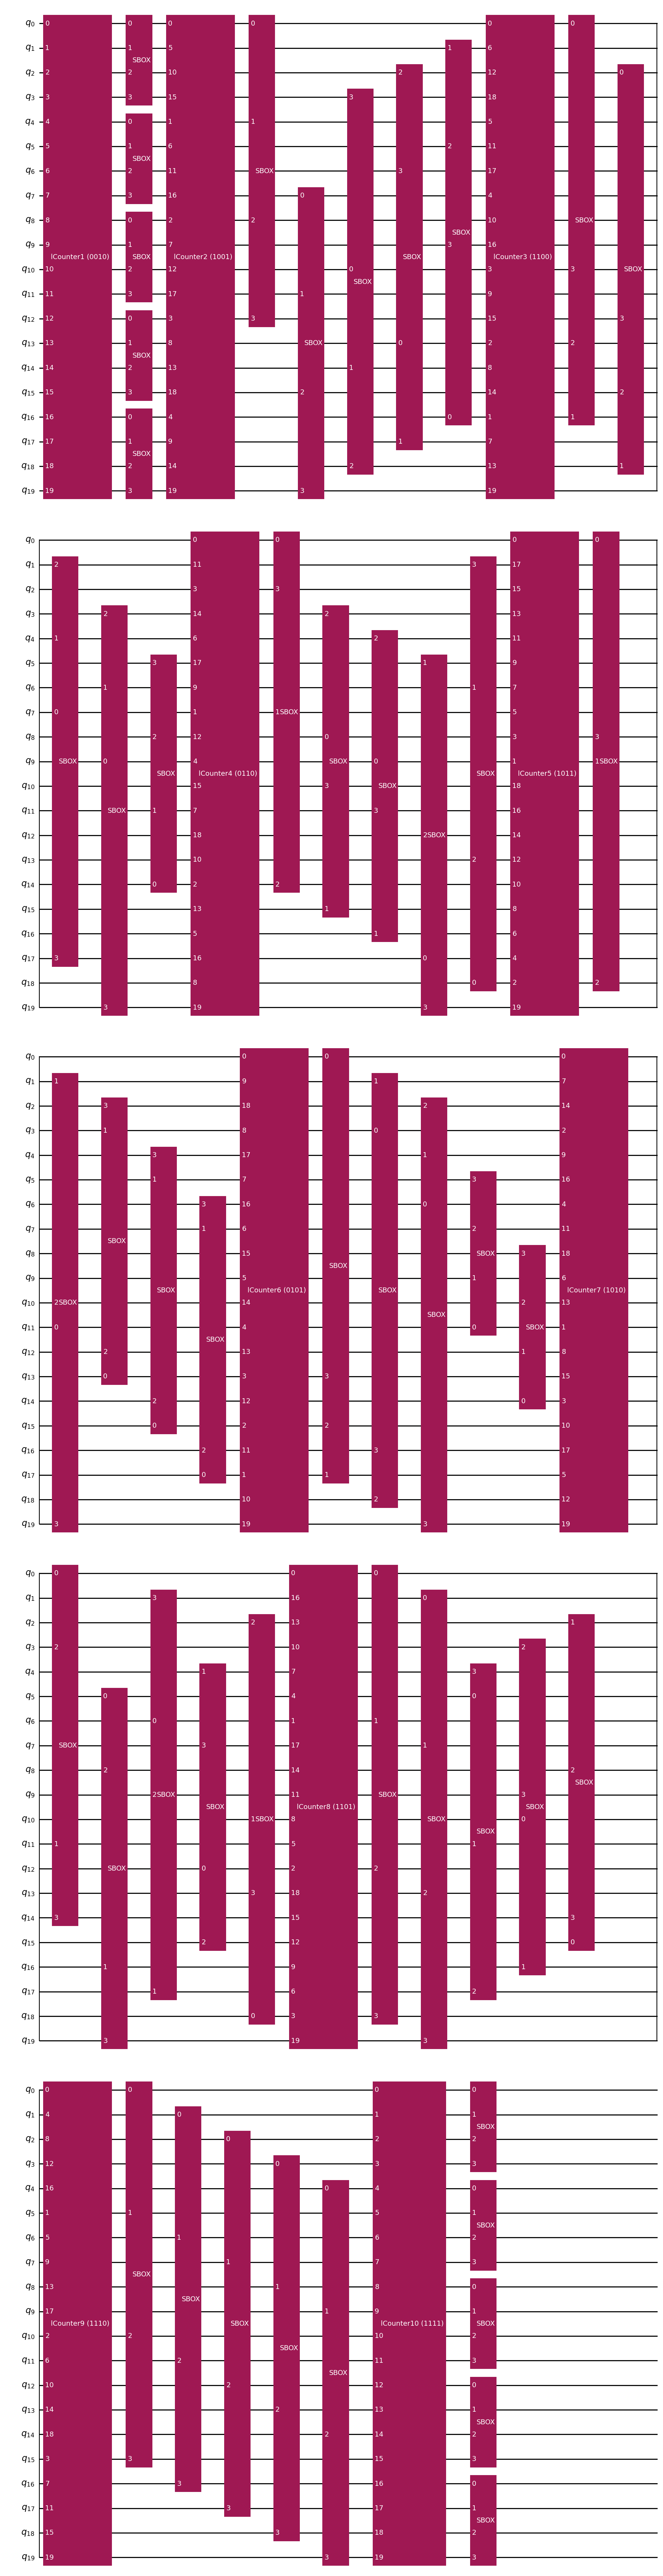

In [18]:
def get_new_mapping(mapping):
    new_mapping = []
    qargs = [-1]*len(mapping)
    for i, val in enumerate(mapping):
        permuted_index = get_permuted_index(val)
        qargs[permuted_index] = i
        new_mapping.append(permuted_index)

    return qargs, new_mapping


def pi_20_permutation(rounds=10):
    circuit = QuantumCircuit(20)
    mapping = list(range(20))
    qargs = list(range(20))

    for round in range(1, rounds + 1):       
        circuit.append(permutation_stage_gate(round)[1], qargs)
        qargs, mapping = get_new_mapping(mapping)
    return circuit, circuit.to_gate(label="PI20"), mapping

test_pi_20_permutation_circuit, _, _ = pi_20_permutation()
test_pi_20_permutation_circuit.decompose(reps=1).draw("mpl")

def pi_20_permutation_no_sbox(rounds=10):
    circuit = QuantumCircuit(20)
    mapping = list(range(20))
    qargs = list(range(20))

    for round in range(1, rounds + 1):
        if round == rounds:
            circuit.append(l_counter_circuit(round)[1], qargs)
        else:
            circuit.append(permutation_stage_gate(round)[1], qargs)
        qargs, mapping = get_new_mapping(mapping)
    return circuit, circuit.to_gate(label="PI20"), mapping

test_pi_20_permutation_circuit, _, _ = pi_20_permutation()
test_pi_20_permutation_circuit.decompose(reps=1).draw("mpl")

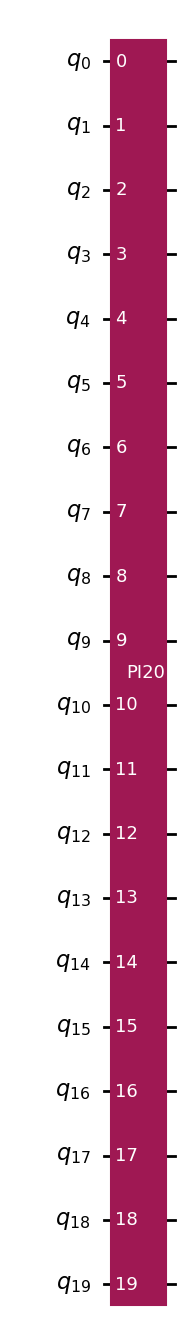

In [19]:
test_pi_gate = QuantumCircuit(20)
test_pi_gate.append(pi_20_permutation()[1], list(range(20)))
test_pi_gate.draw("mpl")

In [20]:
from qiskit_aer import AerSimulator

_, pi_20_gate, mapping = pi_20_permutation_no_sbox(2)

qc = QuantumCircuit(20)
qc.append(pi_20_gate, list(range(20)))
qc.measure_all()

simulator = AerSimulator()

decomp = qc.decompose(reps=2)
decomp.draw("mpl")

job = simulator.run(qc.decompose(reps=3), shots=1)

result = job.result()
counts = result.get_counts()

# Display results
print(counts)
print(mapping)

{'10101111111001101010': 1}
[0, 6, 12, 18, 5, 11, 17, 4, 10, 16, 3, 9, 15, 2, 8, 14, 1, 7, 13, 19]


In [21]:
lfsr_state(2)

'1001'

In [22]:
message = "10000000000000000001"
chunks = [message[i:i+4] for i in range(0, 20, 4)]
full_circuit = QuantumCircuit(36)
for qubit, value in enumerate(message[::-1]):
    if value == '1':
        full_circuit.x(qubit)

_, pi_20_permutation_gate, pi_20_mapping = pi_20_permutation()

full_circuit.append(pi_20_permutation_gate, {(i if i < 4 else i + 16):i  for i in range(20)})
for qubit in range(4, 8):
    if qubit == 4:
        full_circuit.cx(qubit, 0)
    else:
        full_circuit.cx(qubit, pi_20_mapping[qubit-4] + 16)
full_circuit.append(pi_20_permutation_gate, )
print(pi_20_mapping)
    
full_circuit.draw("mpl")


CircuitError: 'The amount of qubit(0)/clbit(0) arguments does not match the gate expectation (20).'